# Predicting Boston Housing Prices
### by Wenzhe Ding

In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

## Table of contents
- [Data Source](#ds)
- [Data Exploration](#de)
   - [Statistics](#stats)
   - [Feature Observation](#fo)
- [Developing a Model](#dam)
   - [Define a Performance Metric](#dapm)
   - [Goodness of Fit](#gof)
   - [Shuffle and Split Data](#sasd)
   - [Training and Testing](#tat)
- [Analyzing Model Performance](#amp)
   - [Learning Curves](#lc)
   - [Complexity Curves](#cc)
   - [Bias-Variance Tradeoff](#bvt)
   - [Best-Guess Optimal Model](#bgom)
- [Evaluating Model Performance](#emp)
   - [Grid Search](#gs)
   - [Cross-Validation](#cv)
   - [Fitting a Model](#fam)
   - [Making Predictions](#mp)
   - [Sensitivity](#s)
- [Applicability](#a)

----
<a id='ds'></a>
## Data Source
[[ go back to the top ]](#Table-of-contents)

The dataset for this project originates from the [UCI Machine Learning Repository](hhttps://archive.ics.uci.edu/ml/machine-learning-databases/housing/?C=N;O=A). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [40]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit
import warnings
warnings.filterwarnings('ignore')
# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


----
<a id='de'></a>

## Data Exploration
[[ go back to the top ]](#Table-of-contents)

In this first section of this project, I made a cursory investigation about the Boston housing data and provide our observations. Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

<a id='stats'></a>
### Statistics
[[ go back to the top ]](#Table-of-contents)

We will calculate descriptive statistics about the Boston housing prices using `numpy` to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, we will implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

In [41]:
# TODO: Minimum price of the data
minimum_price = np.min(prices)

# TODO: Maximum price of the data
maximum_price = np.max(prices)

# TODO: Mean price of the data
mean_price = np.mean(prices)

# TODO: Median price of the data
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


In [42]:
features.describe()

,RM,LSTAT,PTRATIO
count,489.000000,489.000000,489.000000
mean,6.240288,12.939632,18.516564
std,0.643650,7.081990,2.111268
min,3.561000,1.980000,12.600000
25%,5.880000,7.370000,17.400000
50%,6.185000,11.690000,19.100000
75%,6.575000,17.120000,20.200000
max,8.398000,37.970000,22.000000


<a id='fo'></a>
### Feature Observation
[[ go back to the top ]](#Table-of-contents)

As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

Typically, a home that has more rooms would worth more, therefore we expect an increase in the value of 'RM' would lead to an increase in the value of 'MEDV'. In addition, a home price would decrease as the persentage of low income homeowners in the neighborhood increase, so an increase in the value of 'LSTAT' would lead to a decrease in the value of 'MEDV'. Furthermore, a better neighborhood would have a better school and thus a lower ratio of students to teachers. Thus, an increase in the value of 'PTRATIO' would lead to a decrease in the value of 'MEDV'. Our expectation is justified by the signs of the correlation coefficient in the correlation matrix below.

In [43]:
data.corr()

,RM,LSTAT,PTRATIO,MEDV
RM,1.000000,-0.612033,-0.304559,0.697209
LSTAT,-0.612033,1.000000,0.360445,-0.760670
PTRATIO,-0.304559,0.360445,1.000000,-0.519034
MEDV,0.697209,-0.760670,-0.519034,1.000000


----
<a id='dam'></a>
## Developing a Model
[[ go back to the top ]](#Table-of-contents)

In this second section of the project, we will develop the tools and techniques necessary for a model to make a prediction.

<a id='dapm'></a>
### Define a Performance Metric
[[ go back to the top ]](#Table-of-contents)

It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will calculate the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, we will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [44]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)  
    
    # Return the score
    return score

<a id='gof'></a>
### Goodness of Fit
[[ go back to the top ]](#Table-of-contents)

Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |


In [45]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


Over 90% of the total variation is explained by the model, so we consider this model to have successfully captured the variation of the target variable. 

<a id='sasd'></a>
### Shuffle and Split Data
[[ go back to the top ]](#Table-of-contents)

Our next implementation splits the Boston housing dataset into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, we will implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of our choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [46]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


<a id='tat'></a>
### Training and Testing
[[ go back to the top ]](#Table-of-contents)

**Benefit to splitting a dataset: ** We split the dataset into training and testing subsets so that we can use training data to come up with the model while the testing dataset will test the model. If we do not do this step, it is very likely our model overfits the training data because we are putting too much focus on training the model without evaluating its performance on unseen data sets.

----
<a id='amp'></a>
## Analyzing Model Performance
[[ go back to the top ]](#Table-of-contents)

In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing our model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

<a id='lc'></a>
### Learning Curves
[[ go back to the top ]](#Table-of-contents)

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

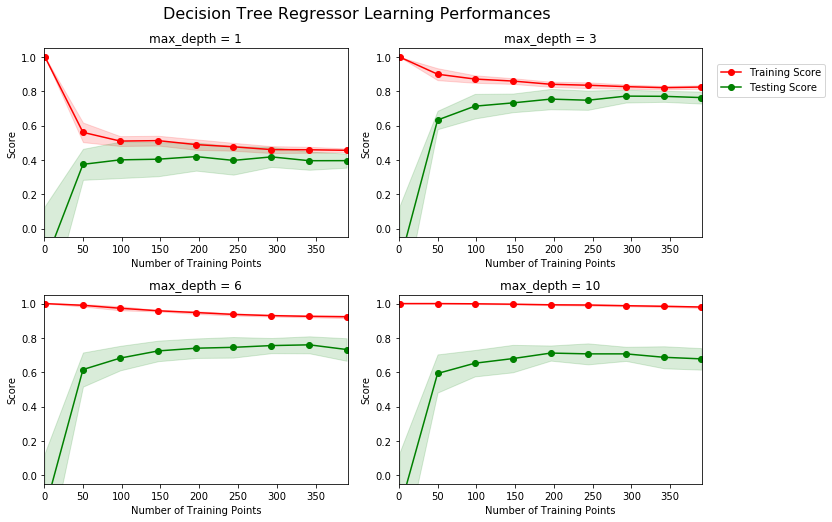

In [47]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

**Analysis of graphs: ** The bottom left graph shows the learning curve with a maximum depth of 6. This graph demonstrates a problematic situation that the model suffers from high variance as neither the test error nor training error converge and the traing score is much higher than the testing score. In the beginning phases, adding more training points helped both training score and testing score coverge. However, both scores have plateaued after 200 or so training points, adding more training points will not help improve the training score nor the testing error afterwards. A model with high variance does not generalize well to an independent dataset. To deal with this situation, we can simplify the model with fewer or less complex features to improve the performance of this model. 

<a id='cc'></a>
### Complexity Curves
[[ go back to the top ]](#Table-of-contents)

The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

Run the code cell below and use this graph to answer the following two questions.

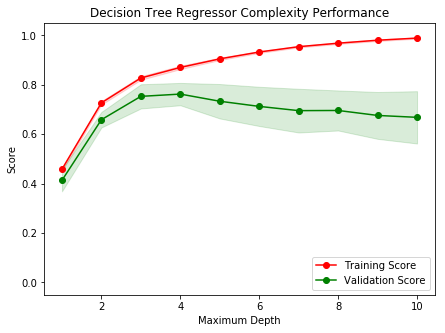

In [48]:
vs.ModelComplexity(X_train, y_train)

<a id='bvt'></a>
### Bias-Variance Tradeoff
[[ go back to the top ]](#Table-of-contents)

**Analysis: ** The model suffers from high bias when it is trained with a maximum depth of 1 as both training and validation scores are lowest. When the model is trained with a maximum depth of 10, it has an overfitting problem as the training score is much larger than the validation score, meaning that the model fits too much noise of the training data and does not generalize well to an independent dataset. 

<a id='bgom'></a>
### Best-Guess Optimal Model
[[ go back to the top ]](#Table-of-contents)

**Choosing maximum depth: ** A model with maximum depth of 3 will best generalize to unseen data. Based on the graphs of learning curves, it is clear that the model with maximum depth of 3 have both training and test score converged. In addition, the difference between the training score and validation score is smallest when the maximum depth reaches 3 and  the validation score is highest in this case meaning that the models does not overfit or underfit the data in this case. 

-----
<a id='emp'></a>
## Evaluating Model Performance
[[ go back to the top ]](#Table-of-contents)

In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

<a id='gs'></a>
### Grid Search
[[ go back to the top ]](#Table-of-contents)

Grid search means you have a set of models which differ from each other in their hyperparameter values. It trains each of the models and evaluate it using validation set. It then select the one that performed best. It can help to get the best performance of a learning algorithm for a given data set.

<a id='cv'></a>
### Cross-Validation
[[ go back to the top ]](#Table-of-contents)

In k-fold cross-validation, the data set is divided into k subsets. Each time, one of the k subsets is used as the test set and the other k-1 subsets are put together to form a training set. Then the average error across all k trials is computed.  This technique provides a cross-validated set for grid search in the training phase in order to limit problems like overfitting, and get an insight on how the model will generalize to an independent data set. 

<a id='fam'></a>
### Fitting a Model
[[ go back to the top ]](#Table-of-contents)

Our final implementation brings everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, we will find our implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique we described above, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. 

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, we will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [49]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor 
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=0)

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': [i for i in range(1,11)]}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = GridSearchCV(regressor, param_grid = params,scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

<a id='mp'></a>
### Making Predictions
[[ go back to the top ]](#Table-of-contents)

Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

In [50]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


**Insights: ** Using grid search, we found that the optimal model has a maximum depth of 4, which is close to our guess of 3.

Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  

In [51]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


**Analysis: ** The price that client 1, client 2 and client 3 can sell his/her home at \$403,025.00, \$237,478.72 and \$931,636.36 respectively. These prices are reasonable given the positive correlation bewteen total number of rooms in home and the price, the negative correlation between the poverty level and home price as well as the negative correlation between the student-teacher ratio and home price. Also, based on the statistics of prices in the Data Exploration section, the minimum, mean and maximum of prices are around 100000, 450000 and 1000000 respectively. The prediction results here fit in the overall distributions of prices in the data set.

<a id='s'></a>
### Sensitivity
[[ go back to the top ]](#Table-of-contents)

An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Runing the `fit_model` function ten times with different training and testing sets, we saw how the prediction for a specific client changes with the data it's trained on.

In [52]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39


----
<a id='a'></a>
### Applicability
[[ go back to the top ]](#Table-of-contents)

Note that the constructed model should not be used in a real-world setting due to the following reasons:
* The data collected from 1978 can not represent the current market.
* The data collected in an urban city might not be applicable in a rural city.
* The features present in the data are not sufficient to describe a home, we also want know other informations of a home, such as its size, year of built, etc.
* The model is not a robust model. When we ran the model multiple times with different training and testing sets, the prediction for a specific client changes with the data it's trained on.